# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
#!!get_ipython().magic('matplotlib inline')
import matplotlib
%matplotlib inline

import os
import time
import cv2
import numpy as np
from numpy import float32
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import namedtuple
from tensorflow.contrib.learn.python.learn.datasets.mnist import dense_to_one_hot

print ("All imports successful")


All imports successful


In [2]:
# Some image manipulation routines
# Needed for subsequent processing

# Crops an image based on the coordinates obtained from the input data
# Cropping of data is not useful in this project. But I am keeping it here,
# in case it is needed in the future.
def crop(image, coords, size):
    # Original dimensions of the image
    org_x = size[0]
    org_y = size[1]
    
    # Scaling : Image has been scaled from its original size down to the processing size (32)
    sz_x = len(image)
    sz_y = len(image[0])
    
    # Ratio : Of actual/original (this is to scale the rectangular coordinates around image)
    rat_x = float(sz_x / org_x)
    rat_y = float(sz_y / org_y)
    
    # Rectangle: Scale the rectangular box based on the scaling above
    x1 = rat_x * coords[0]
    x2 = rat_x * coords[2]
    y1 = rat_y * coords[1]
    y2 = rat_y * coords[3]

    cropped = image[x1:x2, y1:y2]

    return cropped

def transform_image(image, ang_range, shear_range, trans_range):
    '''
    This function transforms input_images to generate new input_images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    return image

# Placeholder, in case more image transformations are needed in the future
def sharpen_blur(image):
    return image

# Placeholder, in case more image transformations are needed in the future
def rotate(image):
    return image

# Placeholder, in case more image transformations are needed in the future
def brighten_darken(image):
    return image

# Placeholder, in case more image transformations are needed in the future
def push_away(image, newshape):
    return image

# Placeholder, in case more image transformations are needed in the future
def change_perspective(image):
    return image

# Placeholder, in case more image transformations are needed in the future
def add_noise(image, noise):
    return image

# Adjusts the image size, however it has been obtained, to adhere to input requirements
def resize(image, size):
    if size==image.shape[0] and size==image.shape[1]:
        return image
    
    # we need to keep in mind aspect ratio so the image does
    # not look skewed or distorted -- therefore, we calculate
    # the ratio of the dimensions of the new image to the old image
    r_x = size / image.shape[0]
    r_y = size / image.shape[1]
    dim = (int(image.shape[0] * r_x), int(image.shape[1] * r_y))

    # perform the actual resizing of the image and show it
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized


In [3]:
# This is the actual data generation routine. It's aim is to equalize the distribution of training samples
# so that training is not only more generalized, but also does not skew towards specific classes.
# This method also prints out the distribution of examples across the training classes.

def equalize_distribution(xs, ys, coords, sizes):
    more_images = []
    more_labels = []
    
    (num_images, img_size, _, num_channels) = xs.shape

    (unique, counts) = np.unique(ys, return_counts=True)
    maxcount = max(counts)
    mincount = min(counts)
    delta_threshold = 25 # percent
    
    n_classes = len(unique) # Now we will assume that the uniques are 0..n (strictly increasing and continuous)
    # Calculate inverse lookup
    inverse = np.empty((n_classes, 0)).tolist()
    for i in range(len(xs)):
        inverse[ys[i]].append(i)

    if (100 - (mincount * 100 / maxcount)) > delta_threshold:
        idealcount = maxcount #int(maxcount + .25 * maxcount)
        descending = np.argsort(counts)[::-1] # Sort the classes in descending order based on 'counts' array values
        for cls in descending:
            needed = idealcount - counts[cls]
            print ("Class\t{}:\t{} examples \t[% = {}\tNeed = {} more]".format(cls, counts[cls], counts[cls]*100/num_images, needed))
            
            # Perform a sequence of modifications to generate the 'needed' new data, using
            # a uniform distribution for the actual modifications
            if (needed > 0):
                images = [xs[i] for i in inverse[cls]]  # Get the exact indices of each image for the current class

                for idx in range(needed):
                    i = idx % len(images)
                    image = images[i]
                    # Can look at: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
                    #   for ideas for image transformations
                    #image = crop(image, coords[i], sizes[i])
                    #image = addnoise(image, 5)
                    #image = rotate(image)
                    #image = sharpen_blur(image)
                    #image = push_away(image, (img_size, img_size, num_channels))
                    #image = change_perspective(image)
                    image = transform_image(image, 20, 10, 5)
                    image = resize(image, img_size) # Get image back to required size, in case that changed
                    
                    more_images.append(image)
                    more_labels.append(cls)
        
    return more_images, more_labels


In [4]:
# Utility function used to plot 9 input_images in a 3x3 grid, and writing the true and 
# predicted classes below each image.
def plot_images(images, actual_labels, label_predictor=None):
    assert len(images) == len(actual_labels) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if label_predictor is None:
            xlabel = "True: {0}".format(actual_labels[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(actual_labels[i], label_predictor[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Function for plotting examples of input_images from the test-set that have been mis-classified.
def plot_example_errors(data, predictions, gradings):
    incorrect = (gradings == False)
    images = data.images[incorrect] #images = [ data.images[i] for i in range(data.count) where incorrect[i]]
    predictions = predictions[incorrect]
    actuals = data.labels[incorrect]
    plot_images(images=images[0:9], actual_labels=actuals[0:9], predictions=predictions[0:9])

# Helper-function for plotting an image.
def plot_image(image):
    plt.imshow(image.reshape(img_shape), interpolation='nearest', cmap='binary')
    plt.show()


In [5]:
# Load test and training data from input files
import pickle
training_file = 'data/train.p'
testing_file = 'data/test.p'
more_data_file = 'data/more_data.p'
checkpoint_file = 'checkpoints/checkpoint.chk'
abort_file = 'abort'

FEATURES = 'features'
LABELS = 'labels'
SIZES = 'sizes'
COORDS = 'coords'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

x_train, y_train, sizes_train, coords_train = train[FEATURES], train[LABELS], train[SIZES], train[COORDS]
x_test, y_test, sizes_test, coords_test = test[FEATURES], test[LABELS], test[SIZES], test[COORDS]

print ("Test and trainign data loaded")

Test and trainign data loaded


In [6]:
# Read in initial data for pre-processing
img_size = len(x_train[0])
num_channels = len(x_train[0][0][0])
img_shape = x_train[0].shape #(img_size, img_size, num_channels)

# Augmenting data
# NOTE: Please delete the file named "more.p" from the current directory in order for the raw data generation
#       to generate new data and print information about the training set distribution
augment_data = True
if augment_data:
    print ("Processing augmentation...")
    if not os.path.isfile(more_data_file):
        print ("\tGenerating fresh data...")
        more_images, more_labels = equalize_distribution(x_train, y_train, coords_train, sizes_train)
        if (len(more_images)>0):
            print('\t\tSaving data to pickle file...')
            try:
                with open(more_data_file, 'wb') as pfile:
                    pickle.dump(
                        {
                            FEATURES: more_images,
                            LABELS: more_labels,
                        },
                        pfile, pickle.HIGHEST_PROTOCOL)
                print ('\t\tGenerated and saved ({} input_images) for subsequent use.'.format(len(more_images)))
            except Exception as e:
                print('\t\tUnable to save data to', more_data_file, ':', e)
                raise
    else:
        print ("\tData already exists.")
    
    with open(more_data_file, 'rb') as f:
        print ("\tReading in augmented data...")
        more = pickle.load(f)
        x_more, y_more = more[FEATURES], more[LABELS]
        print ("\t\tAugmented data count:\t{}".format(len(x_more)))
        #plot_images(x_more[0:9], actual_labels=y_more[0:9])
        x_train = np.concatenate((x_train, x_more))
        y_train = np.concatenate((y_train, y_more))

# Free up some memory
del sizes_train, sizes_test, coords_train, coords_test

Processing augmentation...
	Data already exists.
	Reading in augmented data...
		Augmented data count:	57541


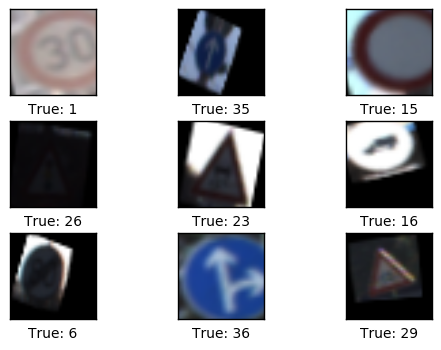

In [7]:
# Visualize the augmented data
ids = [0, 7000, 15000, 17000, 20000, 25000, 27000, 30000, 40000]
x_tmp = [x_more[i] for i in ids]
y_tmp = [y_more[i] for i in ids]
plot_images(x_tmp, y_tmp, None)

In [8]:
# Additional pre-processing.

# Normalize the input_images (and save originals)
x_train_norm = np.zeros_like(x_train, dtype=float32)
x_test_norm = np.zeros_like(x_test, dtype=float32)
for i in range(0, len(x_train)):
    cv2.normalize(x_train[i], x_train_norm[i], 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
for i in range(0, len(x_test)):
    cv2.normalize(x_test[i], x_test_norm[i], 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Some more data analysis
num_classes = len(np.unique(y_train))
y_train_hot = dense_to_one_hot(y_train, num_classes) # One-hot encode all the labels
y_test_hot = dense_to_one_hot(y_test, num_classes) # One-hot encode all the labels

print ("Normalization succeeded")

Normalization succeeded


In [9]:
# Define container for all data related to training/testing, meta data, and parameters:
Data = namedtuple ('Data', ['images', 'pre_images', 'labels', 'hot_labels', 'count', 'batch_size'])
Meta = namedtuple ('Meta', ['image_shape', 'num_channels', 'num_classes'])
Params = namedtuple ('Params', ['num_train_epochs', \
                                'learning_rate', \
                                'dropout', \
                                'validation_set_size', \
                                'validation_frequency', \
                                'training_accuracy_threshold', \
                                'do_checkpointing'])


#
#  These parameters can be tweaked to control the network behavior
#
#

# Create the data objects that will be used going forward
train = Data(x_train_norm, x_train, y_train, y_train_hot, len(x_train), batch_size=128) # Use the normalized input_images (x_train_norm)
test = Data(x_test_norm, x_test, y_test, y_test_hot, len(x_test), batch_size=256) # Use the normalized input_images (x_test_norm)
meta = Meta(x_test_norm[0].shape, len(x_test[0][0][0]), num_classes)
params = Params (\
                 num_train_epochs=1,
                 learning_rate=1e-3,
                 dropout=0.5, # this is actually keep_prob
                 validation_set_size=int(0.10 * train.count),
                 validation_frequency=100, # Validation is performed every 'n' batches
                 training_accuracy_threshold=0.91, \
                 do_checkpointing=False) # Turn this to true if we want checkpointing after every training epoch

print("Size of:")
print("- Training-set:\t\t{}".format(train.count))
print("- Test-set:\t\t{}".format(test.count))
print("- Shape:\t\t{}".format(meta.image_shape))
print("- Num channels:\t{}".format(meta.num_channels))
print("- Num classes:\t{}".format(meta.num_classes))


Size of:
- Training-set:		96750
- Test-set:		12630
- Shape:		(32, 32, 3)
- Num channels:	3
- Num classes:	43


In [10]:
# Utility methods for generating network layers

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=False):  # Use 2x2 max-pooling.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

# A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True):  # Use Rectified Linear Unit (ReLU)?
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer


In [11]:
# More utility methods

# Generates a set of batch ranges, to simplify the process of running batch training/testing
def generate_batches(data):
    batches = []
    num_batches = int(np.ceil(data.count / data.batch_size))
    for batch in range(num_batches):
        i = batch * data.batch_size
        j = i + min(data.batch_size, data.count - i)
        batches.append((i, j))
    return batches

# Utility method to shuffle the training and testing data:
def shuffle (data):
    seq = np.arange(0, len(data.images))
    np.random.shuffle(seq)
    images = np.array([ data.images[i] for i in seq])
    pre_images = np.array([ data.pre_images[i] for i in seq])
    labels = np.array([ data.labels[i] for i in seq])
    hot_labels = np.array([ data.hot_labels[i] for i in seq])
    return Data(images=images, pre_images=pre_images, labels=labels, hot_labels=hot_labels, count=len(images), batch_size=data.batch_size)

# Method to check the accuracy of a given neural network, given some test data, meta data and hyper parameters
def check_accuracy(label_predictor, data, meta, params):
    tmp = data
    predictions = np.zeros(shape=data.count, dtype=np.int)
    batches = generate_batches(data)
    for batch in range(len(batches)):
        (i, j) = batches[batch]
        (test_images, hot_labels) = (tmp.images[i:j], tmp.hot_labels[i:j])
        feed_dict_test = {images: test_images, actual_hot_labels: hot_labels, keep_prob: params.dropout}
        predictions[i:j] = session.run(label_predictor, feed_dict=feed_dict_test)

    gradings = (data.labels == predictions)
    correct_sum = gradings.sum()
    acc = float(correct_sum) / data.count    
    return correct_sum, acc, label_predictor, gradings

In [12]:
# Method to train the network over one epoch of data
def train_epoch(optimizer, predictor, data, meta, params):
    epoch_start_time = time.time()

    # Prepare split (it is assumed that the data is already shuffled)
    num_train_samples = data.count - params.validation_set_size # Keep the last few for validation
    print ("\t\tSplit:\tTraining = {} samples\t /\t Validation = {} samples ({:.1%}) split".format(num_train_samples, \
                                                                                               num_train_samples/data.count,\
                                                                                               params.validation_set_size,\
                                                                                               params.validation_set_size/data.count))
    train_data = Data(\
                      images=data.images[0:num_train_samples],
                      pre_images=data.pre_images[0:num_train_samples],
                      labels=data.labels[0:num_train_samples],
                      hot_labels=data.hot_labels[0:num_train_samples],
                      count=num_train_samples,
                      batch_size=data.batch_size)
    validation_data = Data(\
                           images=data.images[num_train_samples:data.count],
                           pre_images=data.pre_images[num_train_samples:data.count],
                           labels=data.labels[num_train_samples:data.count],
                           hot_labels=data.hot_labels[num_train_samples:data.count],
                           count=params.validation_set_size,
                           batch_size=data.batch_size)
    
    train_batches = generate_batches(train_data)
    for train_batch in range(len(train_batches)):
        (i, j) = train_batches[train_batch]
        (train_images, train_hot_labels) = (train_data.images[i:j], train_data.hot_labels[i:j])
        feed_dict_train = {images: train_images, actual_hot_labels: train_hot_labels, keep_prob: params.dropout}
        session.run(optimizer, feed_dict=feed_dict_train)

        # Every 100 batches, we run the validation set:
        if train_batch % params.validation_frequency == 0:
            correct, accuracy, predictions, gradings = check_accuracy(predictor, validation_data, meta, params)
            print("\t\tTraining batch: {:>6}, Validation-Accuracy: {:.1%} ({} / {})".format(train_batch+1, accuracy, correct, validation_data.count))
            #plot_example_errors(validation_data, predictions, gradings)
 
    epoch_end_time = time.time()
    epoch_time_dif = epoch_end_time - epoch_start_time
    print("\t\tEpoch time usage: " + str(timedelta(seconds=int(round(epoch_time_dif)))))


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
#################################
#          PIPELINE             #
#################################

# Convolutional layers:
filter_size1 = 5          # Convolution filters are 5 input_images 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

filter_size2 = 5          # Convolution filters are 5 input_images 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

filter_size3 = 5          # Convolution filters are 5 input_images 5 pixels.
num_filters3 = 128         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 1024             # Number of neurons in fully-connected layer.

# Plot some training samples
#plot_images(images=train.pre_images[0:9], actual_labels=train.labels[0:9])

images = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='images')
actual_hot_labels = tf.placeholder(tf.float32, shape=[None, num_classes], name='actual_hot_labels')
actual_labels = tf.argmax(actual_hot_labels, dimension=1)
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# Network architecture/layers
layer, _ = None, None
layer, _ = layer_conv1, weights_conv1 = new_conv_layer(input=images, num_input_channels=num_channels, filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)
#layer = layer_dropout1 = tf.nn.dropout(layer, keep_prob)

layer, _ = layer_conv2, weights_conv2 = new_conv_layer(input=layer, num_input_channels=num_filters1, filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)
#layer = layer_dropout2 = tf.nn.dropout(layer, keep_prob)

layer, _ = layer_conv3, weights_conv3 = new_conv_layer(input=layer, num_input_channels=num_filters2, filter_size=filter_size3, num_filters=num_filters3, use_pooling=True)
#layer = layer_dropout3 = tf.nn.dropout(layer, keep_prob)

layer, _ = layer_flat, num_features = flatten_layer(layer)

layer = layer_fc1 = new_fc_layer(input=layer, num_inputs=num_features, num_outputs=fc_size, use_relu=True)
layer = layer_dropout4 = tf.nn.dropout(layer, keep_prob)

layer = logits = layer_fc2 = new_fc_layer(input=layer, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)
#layer = logits = layer_dropout5 = tf.nn.dropout(layer, keep_prob)

hot_label_predictor = tf.nn.softmax(logits)
label_predictor = tf.argmax(hot_label_predictor, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=actual_hot_labels)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate).minimize(cost)
#correct_prediction = tf.equal(label_predictor, actual_labels)
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
#
# Finally, we're down to the point when the network is trained
# and the test set is run against it periodically to determine accuracy.
# The parameters used here are to be defined earlier on in this notebook.
#
print ("Intializing session:")
saver = tf.train.Saver()
session = tf.Session()
if (os.path.isfile(checkpoint_file)):
    print ("\tLoading session from pre-existing checkpoint.")
    saver.restore(session, checkpoint_file)
else:
    print ("\tUsing default session initialization. (No checkpoint available to load from)")
    session.run(tf.initialize_all_variables())

# Now start the training epochs
# If a checkpoint has been saved already (checkpoints/checkpoint.chk) this will load
# and continue training where it last was.
# If the params.num_train_epochs is set to None, it will train indefinitely, until 
# params.training_accuracy_threshold is attained.
# If params.do_checkpointing is set to True, the checkpoint will keep getting updated
# with the latest weights/biases etc. For the time being, it is said to False, to
# retain the original trained settings.
unlimited_epochs = params.num_train_epochs == None
if (unlimited_epochs or params.num_train_epochs > 0):
    keep_going = True
    epoch = 0
    while keep_going:
        if os.path.isfile(abort_file):
            print ("\tAbort file found. Aborting training. [To continue, re-run training.]")
            os.remove(abort_file)
            break
    
        print ("\tTraining epoch: {}".format(epoch+1))
        train = shuffle(train)
        train_epoch(optimizer, label_predictor, train, meta, params)
    
        if (params.do_checkpointing):
            print ("\t\tSaving checkpoint.")
            saver.save(session, checkpoint_file)
        else:
            print ("\t\tCheckpointing disabled.")
            
        test = shuffle(test)
        correct, accuracy, predictions, gradings = check_accuracy(label_predictor, test, meta, params)
        print("\t\t\tAccuracy on Test-Set: {0:.1%} ({1} / {2})".format(accuracy, correct, test.count))
            
        if accuracy >= params.training_accuracy_threshold:
            print("\t\t\tAchieved threshold accuracy! Ending training.")
            break
        epoch += 1
        keep_going = unlimited_epochs or epoch < params.num_train_epochs

# This is where the test set is run against the network
test = shuffle(test)
correct, accuracy, predictions, gradings = check_accuracy(label_predictor, test, meta, params)
print("Final accuracy on Test-Set: {0:.1%} ({1} / {2})".format(accuracy, correct, test.count))
print ("\nDONE!")

Intializing session:
	Loading session from pre-existing checkpoint.
	Training epoch: 1
		Split:	Training = 87075 samples	 /	 Validation = 0.9 samples (967500.0%) split
		Training batch:      1, Validation-Accuracy: 97.5% (9436 / 9675)
		Training batch:    101, Validation-Accuracy: 97.1% (9390 / 9675)
		Training batch:    201, Validation-Accuracy: 97.5% (9431 / 9675)
		Training batch:    301, Validation-Accuracy: 98.1% (9488 / 9675)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.